# Exploratory Data Analysis for Hyperpartisan News Detection (Official Training Data)

**Purpose:** Analyze the characteristics of the official SemEval 2019 Task 4 training dataset to understand differences between hyperpartisan and non-hyperpartisan articles and inform modeling strategies. This analysis uses the raw text data as processed by the XML parsing script, which is the input format for the BERT model.


In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize # Needed for more accurate word counts/diversity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import stats
import warnings
import os

warnings.filterwarnings('ignore')

In [7]:
# Download required NLTK resources if not already present
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True) # Still useful for TF-IDF/visualization
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt_tab')  

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/anderstungland/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Set style for visualizations
plt.style.use('fivethirtyeight')
sns.set_palette("deep")
sns.set_context("notebook", font_scale=1.2) # Adjust font scale if needed


In [ ]:
# --- Load the OFFICIAL Training Data ---
# Make sure the xml_parse script has run successfully first
official_data_dir = "hyperpartisan_data_official" 
train_csv_path = os.path.join(official_data_dir, "official_train_data.csv")
test_csv_path = os.path.join(official_data_dir, "official_test_data.csv") # Also load test for comparison

if not os.path.exists(train_csv_path):
    raise FileNotFoundError(f"Training data file not found: {train_csv_path}. Run the XML parsing script.")
if not os.path.exists(test_csv_path):
     raise FileNotFoundError(f"Test data file not found: {test_csv_path}. Run the XML parsing script.")

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path) # Load test set for distribution comparison

# Fill potential NaNs in text column from parsing issues
train_df['text'] = train_df['text'].fillna("")
test_df['text'] = test_df['text'].fillna("")

print("--- Data Loading Complete ---")
print(f"Official Training Set Shape: {train_df.shape}")
print(f"Official Test Set Shape: {test_df.shape}")

# Display basic information about the TRAINING set
print("\n--- Training Set Basic Info ---")
print(f"Hyperpartisan distribution: \n{train_df['hyperpartisan'].value_counts()}")
print(f"Hyperpartisan ratio: {train_df['hyperpartisan'].mean():.2f}")

# Check for missing values
print("\nMissing values in Training Set:")
print(train_df.isnull().sum())

# Display sample columns
print("\nDataset columns:", train_df.columns.tolist())

--- Data Loading Complete ---
Official Training Set Shape: (645, 5)
Official Test Set Shape: (628, 5)

--- Training Set Basic Info ---
Hyperpartisan distribution: 
hyperpartisan
False    407
True     238
Name: count, dtype: int64
Hyperpartisan ratio: 0.37

Missing values in Training Set:
id               0
title            0
text             0
publisher        0
hyperpartisan    0
dtype: int64

Dataset columns: ['id', 'title', 'text', 'publisher', 'hyperpartisan']


## 1. Article Length and Structure Analysis (Using Raw Text)
We analyze features related to the length and basic structure of the articles using the raw text content.

Calculating length and diversity features on raw text...


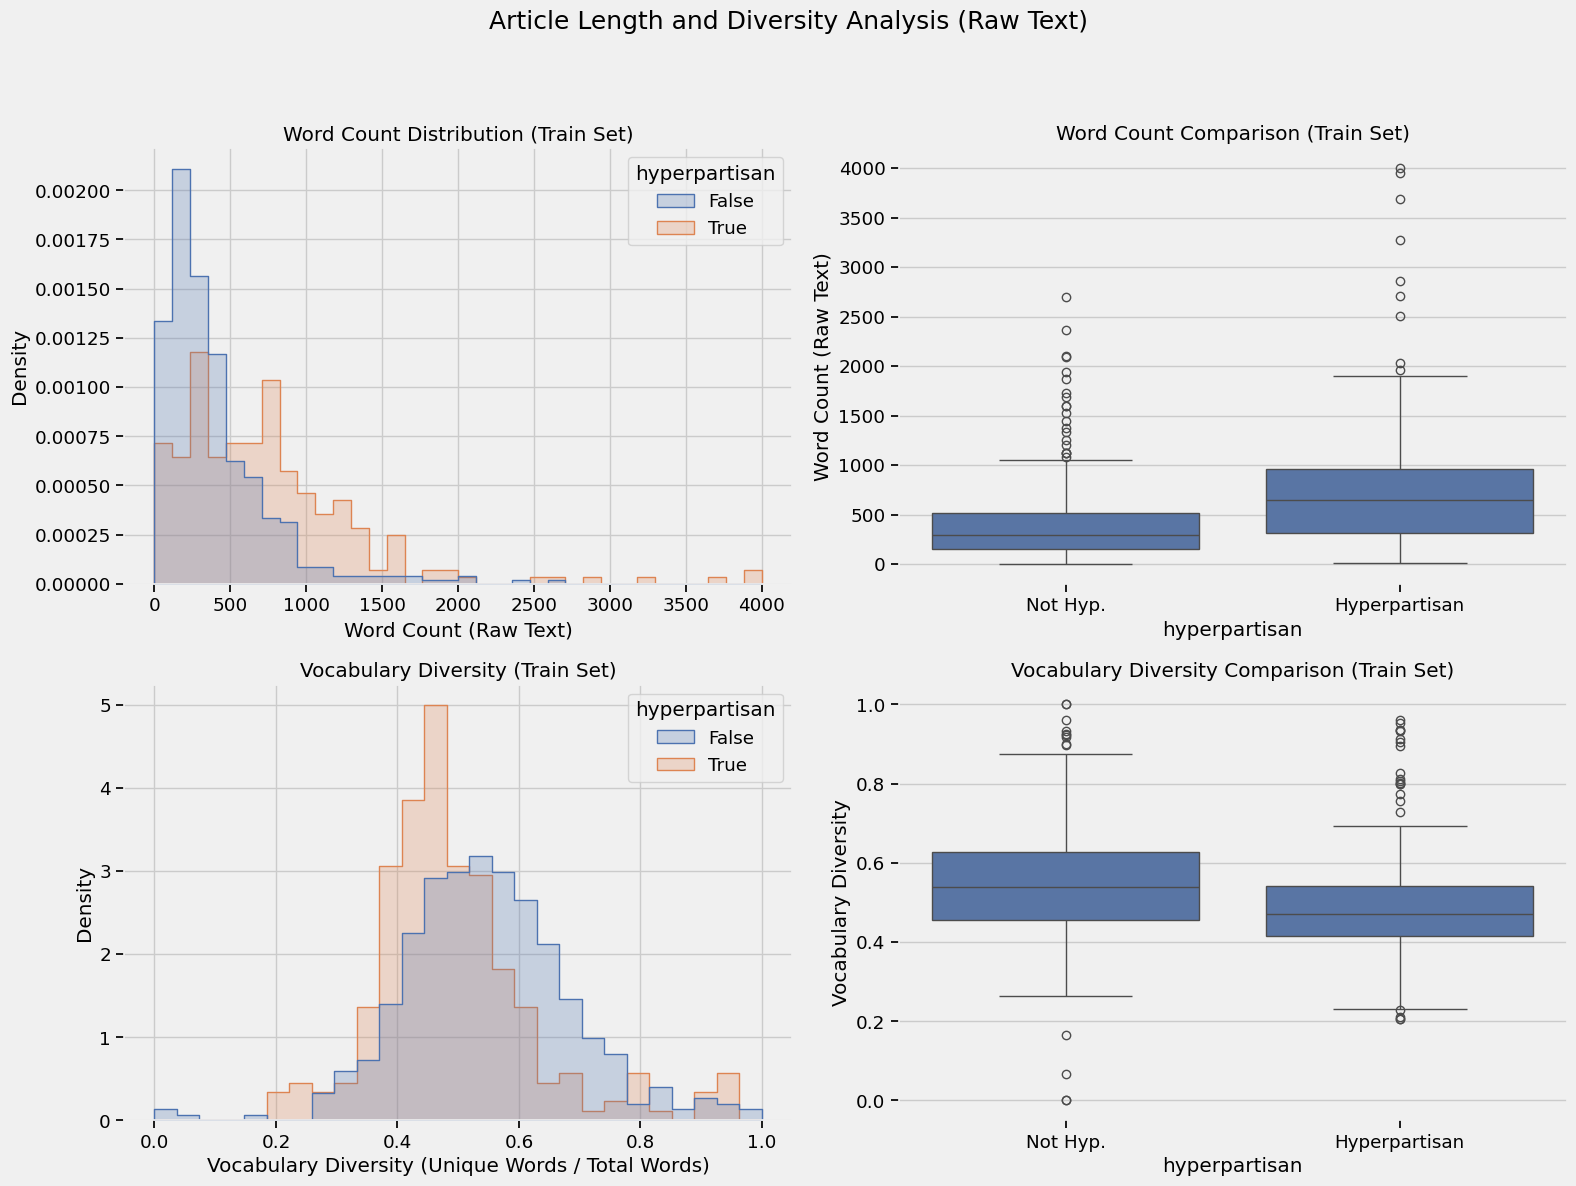


Descriptive statistics for hyperpartisan articles (Train Set):
       word_count_raw  unique_word_count_raw  vocab_diversity_raw
count      238.000000             238.000000           238.000000
mean       743.987395             305.773109             0.495114
std        629.016381             182.150674             0.135820
min         15.000000              14.000000             0.204862
25%        310.250000             170.250000             0.416301
50%        648.500000             297.000000             0.470503
75%        963.000000             419.000000             0.540764
max       4001.000000            1093.000000             0.960000

Descriptive statistics for non-hyperpartisan articles (Train Set):
       word_count_raw  unique_word_count_raw  vocab_diversity_raw
count      407.000000             407.000000           407.000000
mean       396.577396             182.388206             0.548804
std        371.115537             121.433643             0.139714
min       

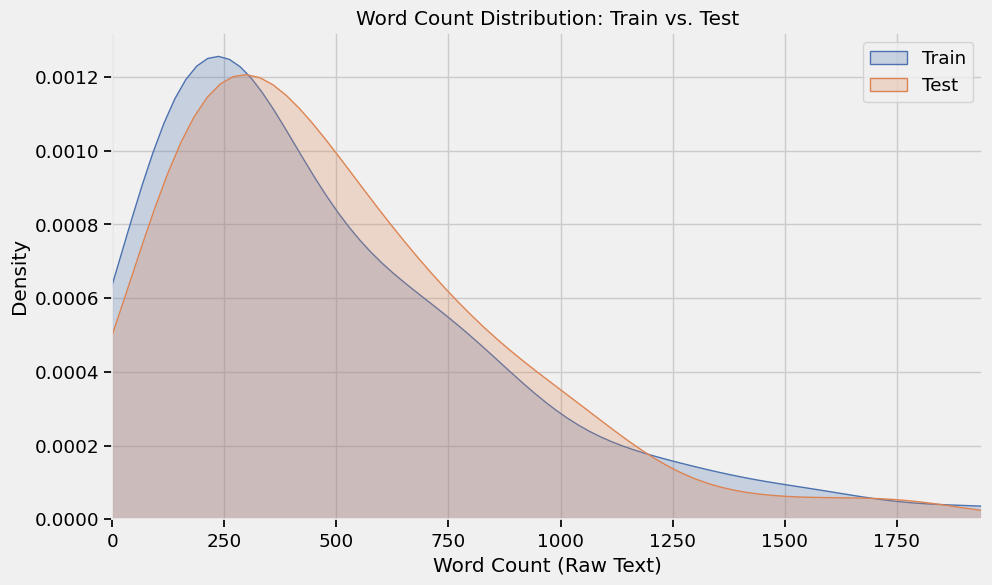

Kolmogorov-Smirnov test for word count distribution (Train vs Test): statistic=0.0856, p-value=0.01738
Note: A small p-value suggests the distributions are statistically different.


In [ ]:
# --- Calculate features based on RAW 'text' column ---
print("Calculating length and diversity features on raw text...")

# Tokenize function using NLTK for potentially better word splitting
def safe_word_tokenize(text):
    try:
        if pd.isna(text):
            return []
        return word_tokenize(str(text).lower()) # Lowercase for unique word count
    except TypeError:
        return []

# Apply calculations to train_df
train_df['char_count'] = train_df['text'].apply(len)
train_df['tokens_raw'] = train_df['text'].apply(safe_word_tokenize) # Tokenize raw text
train_df['word_count_raw'] = train_df['tokens_raw'].apply(len)
train_df['unique_word_count_raw'] = train_df['tokens_raw'].apply(lambda x: len(set(x)))
train_df['vocab_diversity_raw'] = train_df.apply(
    lambda x: x['unique_word_count_raw'] / x['word_count_raw'] if x['word_count_raw'] > 0 else 0,
    axis=1
)

# Apply calculations to test_df for comparison later
test_df['word_count_raw'] = test_df['text'].apply(safe_word_tokenize).apply(len)


# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Article Length and Diversity Analysis (Raw Text)', fontsize=18, y=1.02)

# Plot word count distributions (Training Data)
sns.histplot(data=train_df, x='word_count_raw', hue='hyperpartisan', element='step',
             stat='density', common_norm=False, ax=axes[0, 0])
axes[0, 0].set_title('Word Count Distribution (Train Set)')
axes[0, 0].set_xlabel('Word Count (Raw Text)')
axes[0, 0].set_ylabel('Density')

# Box plot for word count (Training Data)
sns.boxplot(data=train_df, y='word_count_raw', x='hyperpartisan', ax=axes[0, 1])
axes[0, 1].set_title('Word Count Comparison (Train Set)')
axes[0, 1].set_ylabel('Word Count (Raw Text)')
axes[0, 1].set_xticklabels(['Not Hyp.', 'Hyperpartisan'])

# Plot vocabulary diversity (Training Data)
sns.histplot(data=train_df, x='vocab_diversity_raw', hue='hyperpartisan', element='step',
             stat='density', common_norm=False, ax=axes[1, 0])
axes[1, 0].set_title('Vocabulary Diversity (Train Set)')
axes[1, 0].set_xlabel('Vocabulary Diversity (Unique Words / Total Words)')
axes[1, 0].set_ylabel('Density')

# Box plot for vocabulary diversity (Training Data)
sns.boxplot(data=train_df, y='vocab_diversity_raw', x='hyperpartisan', ax=axes[1, 1])
axes[1, 1].set_title('Vocabulary Diversity Comparison (Train Set)')
axes[1, 1].set_ylabel('Vocabulary Diversity')
axes[1, 1].set_xticklabels(['Not Hyp.', 'Hyperpartisan'])

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.savefig("eda_length_diversity.png") # Save the figure
plt.show()

# Display descriptive statistics (Training Data)
print("\nDescriptive statistics for hyperpartisan articles (Train Set):")
print(train_df[train_df['hyperpartisan'] == True][['word_count_raw', 'unique_word_count_raw', 'vocab_diversity_raw']].describe())

print("\nDescriptive statistics for non-hyperpartisan articles (Train Set):")
print(train_df[train_df['hyperpartisan'] == False][['word_count_raw', 'unique_word_count_raw', 'vocab_diversity_raw']].describe())

# Perform statistical tests (Training Data)
print("\n--- Statistical Tests (Train Set) ---")
hyper_word_counts = train_df[train_df['hyperpartisan'] == True]['word_count_raw']
non_hyper_word_counts = train_df[train_df['hyperpartisan'] == False]['word_count_raw']
# Perform test only if both groups have data
if not hyper_word_counts.empty and not non_hyper_word_counts.empty:
    word_count_ttest = stats.ttest_ind(hyper_word_counts, non_hyper_word_counts, equal_var=False, nan_policy='omit')
    print(f"Word count t-test: statistic={word_count_ttest.statistic:.2f}, p-value={word_count_ttest.pvalue:.4g}") # Use g for scientific notation if needed
else:
    print("Could not perform word count t-test (empty group).")

hyper_diversity = train_df[train_df['hyperpartisan'] == True]['vocab_diversity_raw']
non_hyper_diversity = train_df[train_df['hyperpartisan'] == False]['vocab_diversity_raw']
if not hyper_diversity.empty and not non_hyper_diversity.empty:
    diversity_ttest = stats.ttest_ind(hyper_diversity, non_hyper_diversity, equal_var=False, nan_policy='omit')
    print(f"Vocabulary diversity t-test: statistic={diversity_ttest.statistic:.2f}, p-value={diversity_ttest.pvalue:.4g}")
else:
     print("Could not perform diversity t-test (empty group).")

# Compare Train vs Test Word Count Distributions (Optional but recommended)
plt.figure(figsize=(10, 6))
sns.kdeplot(train_df['word_count_raw'], label='Train', fill=True)
sns.kdeplot(test_df['word_count_raw'], label='Test', fill=True)
plt.title('Word Count Distribution: Train vs. Test')
plt.xlabel('Word Count (Raw Text)')
plt.legend()
plt.xlim(0, train_df['word_count_raw'].quantile(0.98)) # Limit x-axis to see main distribution
plt.show()
ks_test = stats.ks_2samp(train_df['word_count_raw'], test_df['word_count_raw'])
print(f"Kolmogorov-Smirnov test for word count distribution (Train vs Test): statistic={ks_test.statistic:.4f}, p-value={ks_test.pvalue:.4g}")
print("Note: A small p-value suggests the distributions are statistically different.")

## 2. Publisher Analysis
Analyzing the source ('publisher' / 'portal') of the articles, as this is known to be a strong indicator of hyperpartisanship.


===== PUBLISHER ANALYSIS (Train Set) =====

Top 15 Publishers (Training Set):
publisher
unknown    645
Name: count, dtype: int64

Hyperpartisan Ratio by Publisher (Top 15 by article count):
           article_count  hyperpartisan_ratio
publisher                                    
unknown              645             0.368992


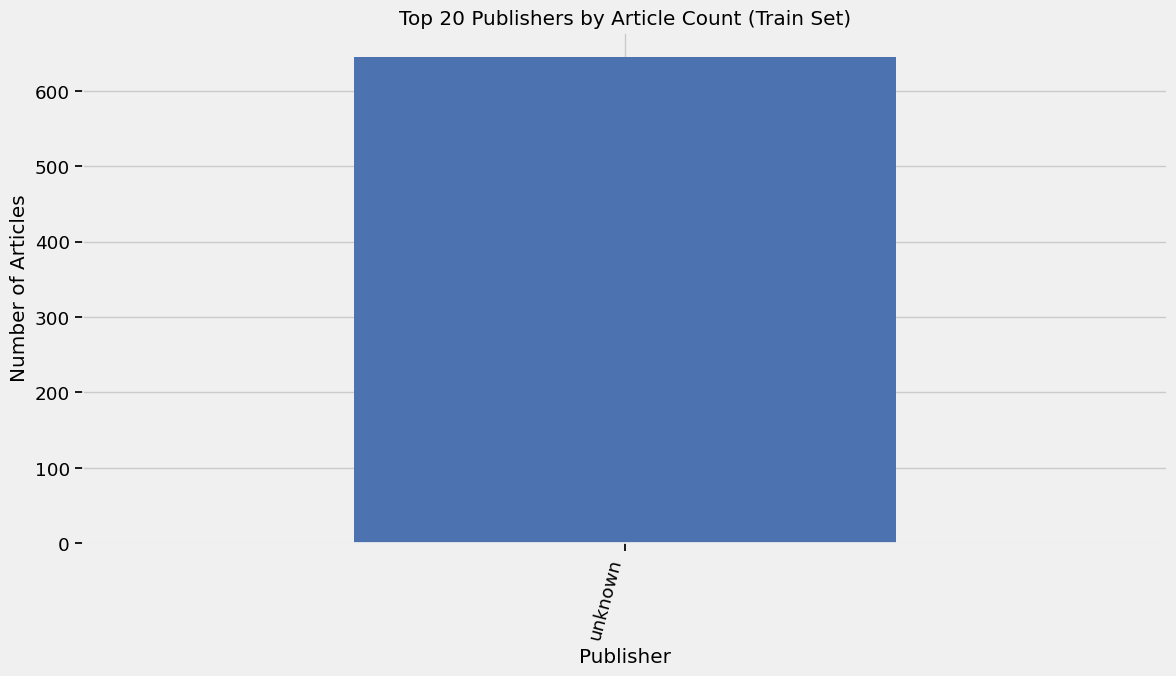

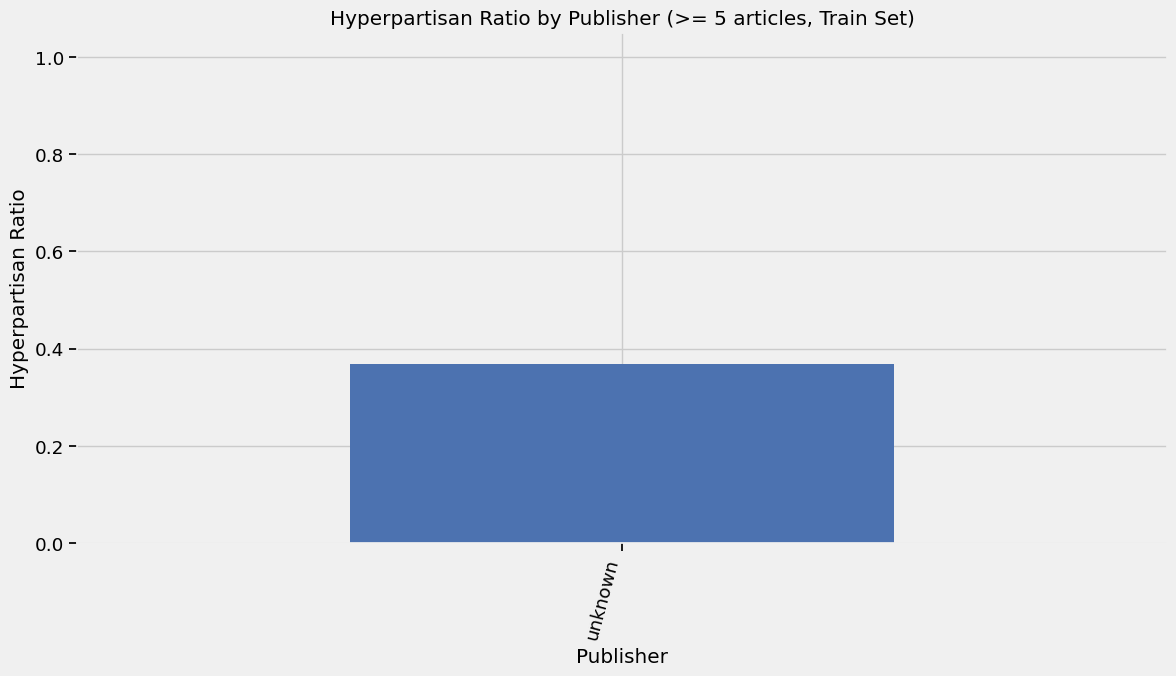


Comparing Publisher Distributions (Train vs Test, Top 10):
           Train  Test
publisher             
unknown      1.0   1.0


In [ ]:
print("\n===== PUBLISHER ANALYSIS (Train Set) =====")

# Publisher value counts
publisher_counts = train_df['publisher'].value_counts()
print("\nTop 15 Publishers (Training Set):")
print(publisher_counts.head(15))

# Hyperpartisan ratio per publisher
publisher_hp_ratio = train_df.groupby('publisher')['hyperpartisan'].mean().sort_values(ascending=False)
publisher_article_count = train_df.groupby('publisher')['hyperpartisan'].count()

# Combine ratio and count for better context
publisher_summary = pd.DataFrame({
    'article_count': publisher_article_count,
    'hyperpartisan_ratio': publisher_hp_ratio
}).sort_values(by='article_count', ascending=False)

print("\nHyperpartisan Ratio by Publisher (Top 15 by article count):")
print(publisher_summary.head(15))

# Visualize top N publishers by count
plt.figure(figsize=(12, 7))
publisher_counts.head(20).plot(kind='bar')
plt.title('Top 20 Publishers by Article Count (Train Set)')
plt.ylabel('Number of Articles')
plt.xlabel('Publisher')
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.savefig("eda_publisher_counts.png")
plt.show()

# Visualize hyperpartisan ratio for publishers with at least N articles
min_articles = 5 # Set a minimum threshold to avoid ratios based on few samples
publishers_filtered = publisher_summary[publisher_summary['article_count'] >= min_articles].sort_values(by='hyperpartisan_ratio', ascending=False)

plt.figure(figsize=(12, 7))
publishers_filtered['hyperpartisan_ratio'].head(25).plot(kind='bar') # Show top 25 by ratio
plt.title(f'Hyperpartisan Ratio by Publisher (>= {min_articles} articles, Train Set)')
plt.ylabel('Hyperpartisan Ratio')
plt.xlabel('Publisher')
plt.xticks(rotation=75, ha='right')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("eda_publisher_ratios.png")
plt.show()

# Compare publisher distribution Train vs Test (Optional)
train_publishers_norm = train_df['publisher'].value_counts(normalize=True)
test_publishers_norm = test_df['publisher'].value_counts(normalize=True)
publisher_comp = pd.DataFrame({'Train': train_publishers_norm, 'Test': test_publishers_norm}).fillna(0)

print("\nComparing Publisher Distributions (Train vs Test, Top 10):")
print(publisher_comp.head(10))
# Note: A large difference might indicate distribution shift, but expected given train/test split nature.

## 3. Common Words and Phrases Analysis (Raw Text)
Identifying common unigrams (words) and bigrams (two-word phrases) in the raw text, comparing hyperpartisan and non-hyperpartisan articles.


===== COMMON WORDS AND PHRASES ANALYSIS (Raw Text) =====


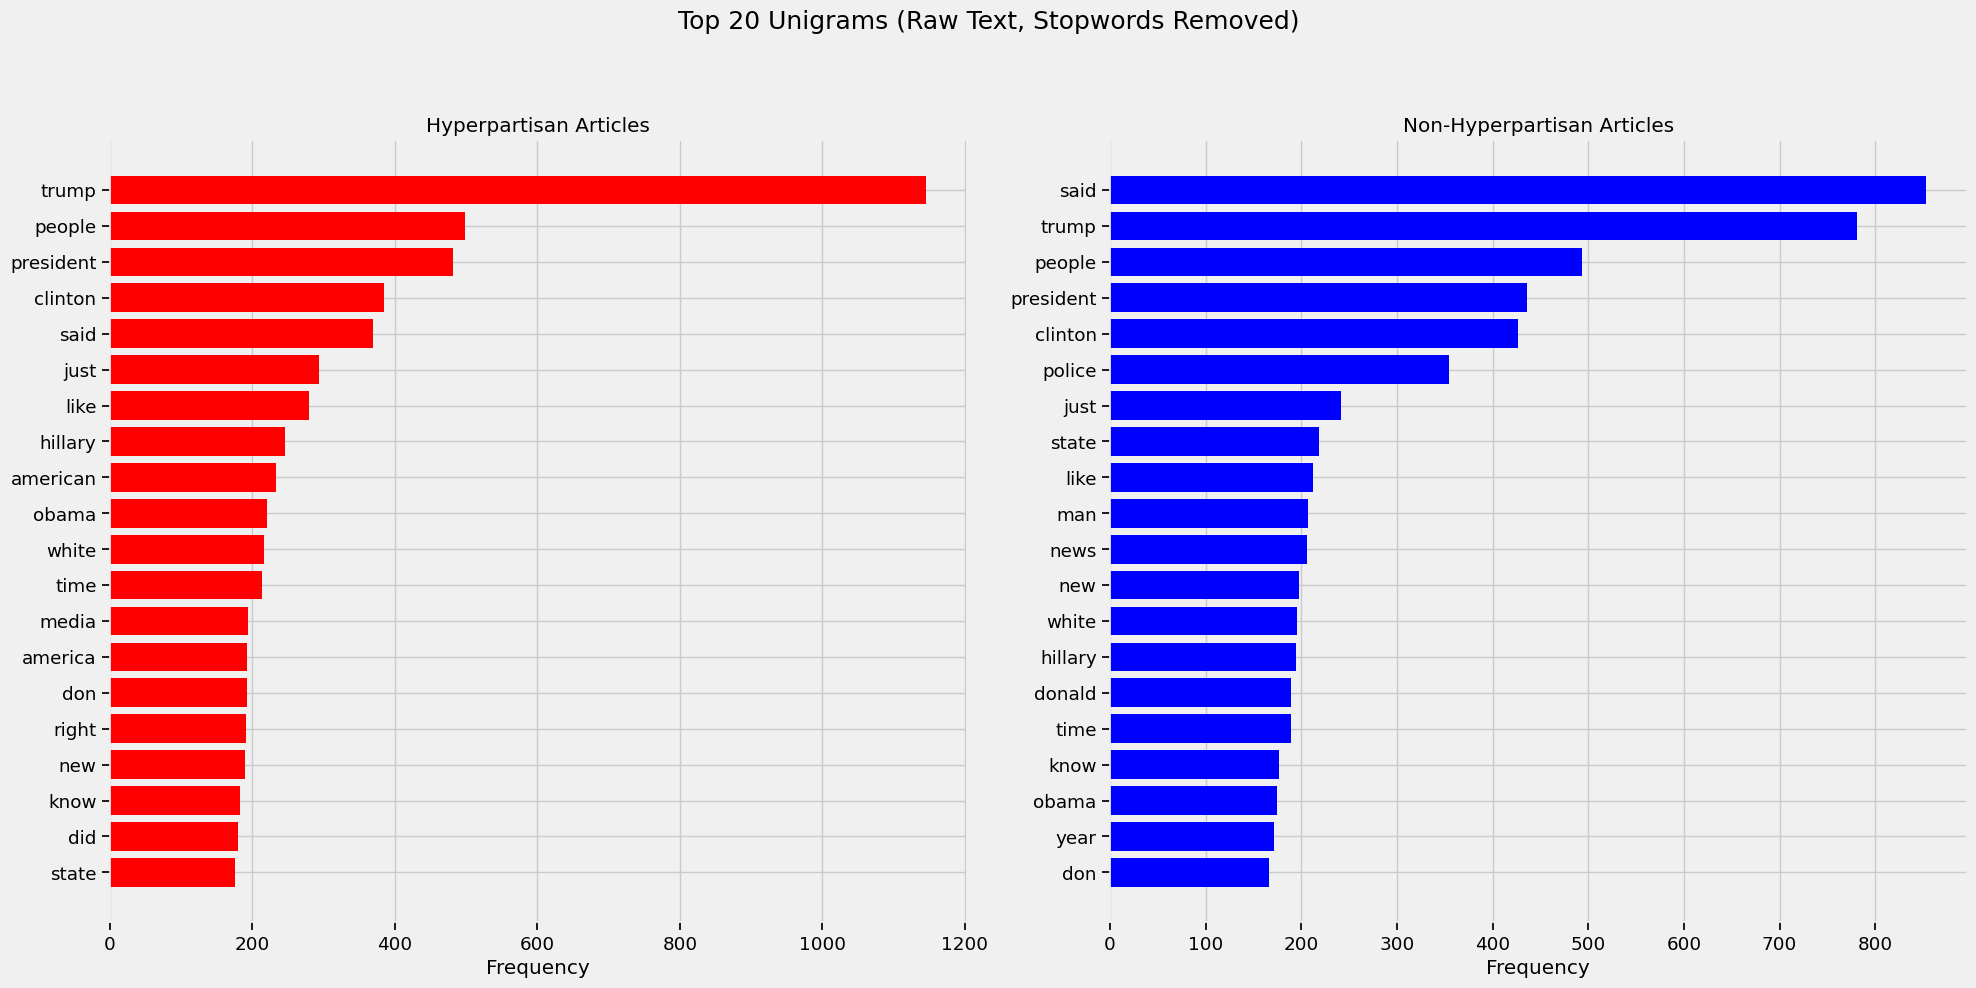


--- Distinctive Words (TF-IDF on Raw Text) ---


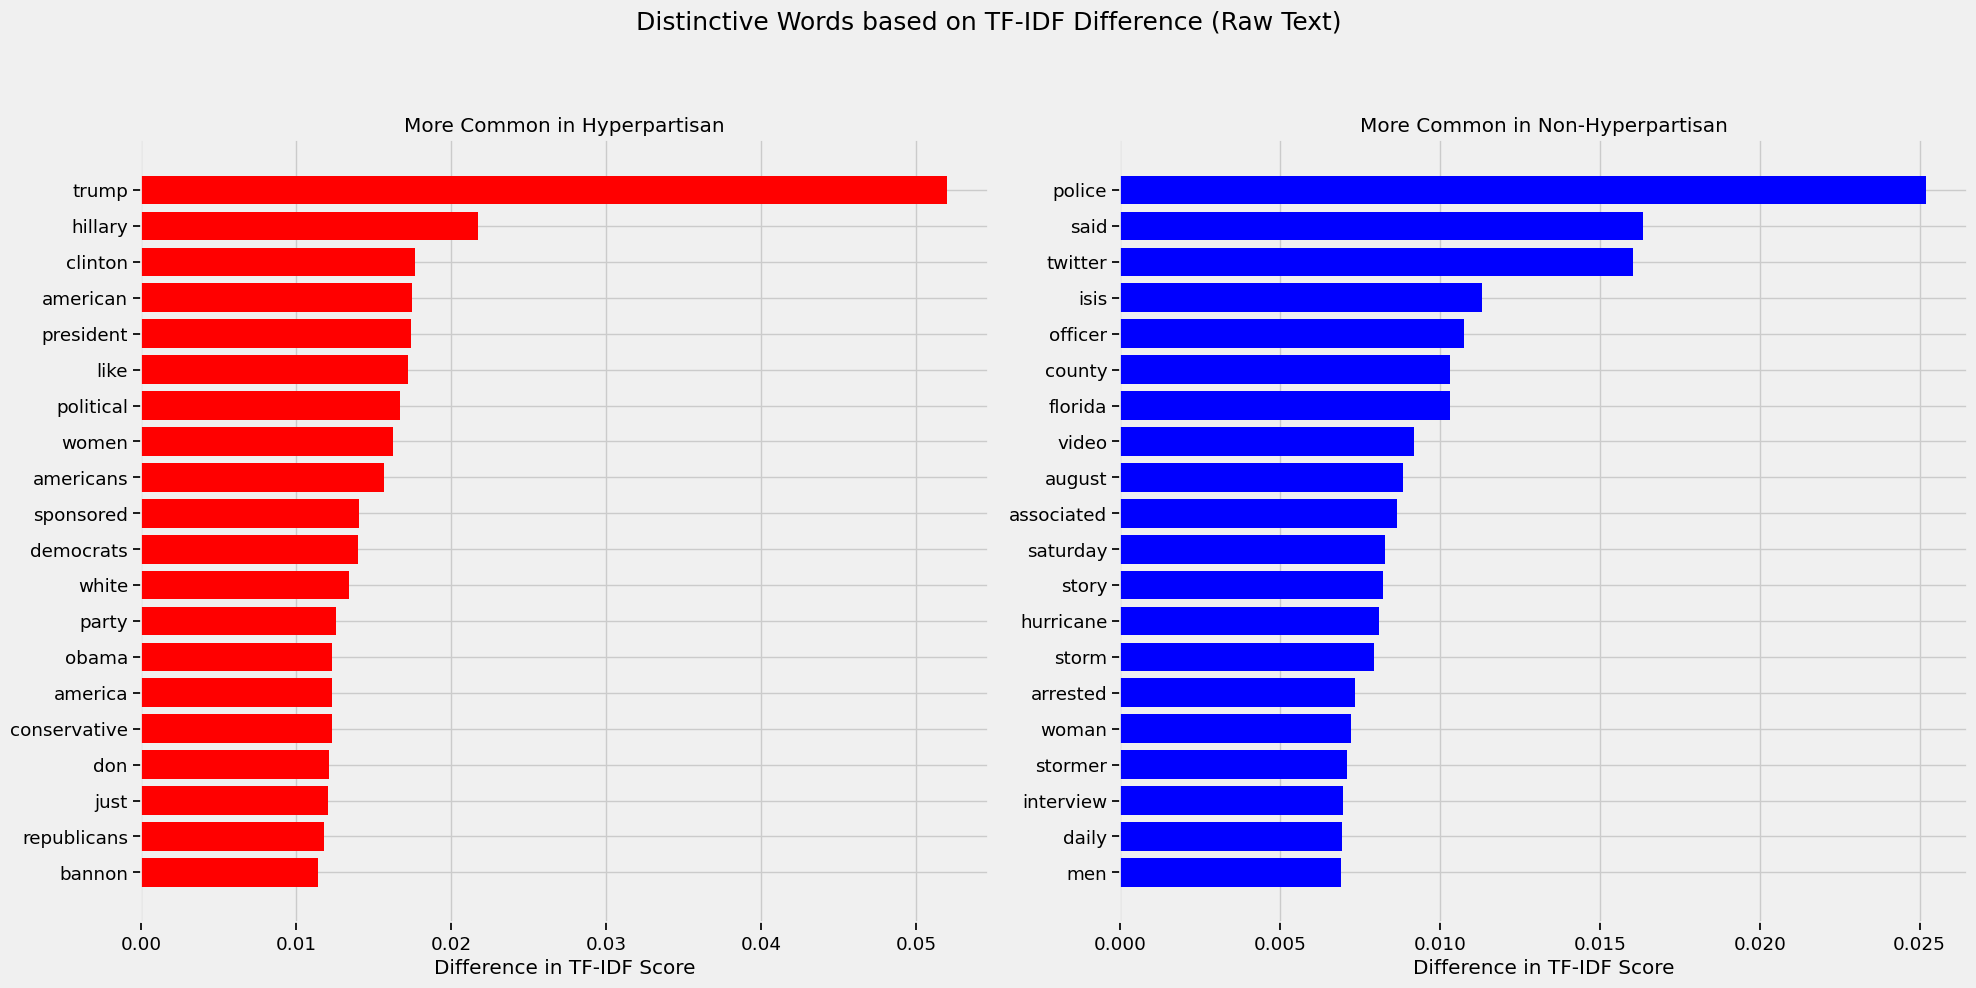


--- Top Bigrams (Raw Text) ---


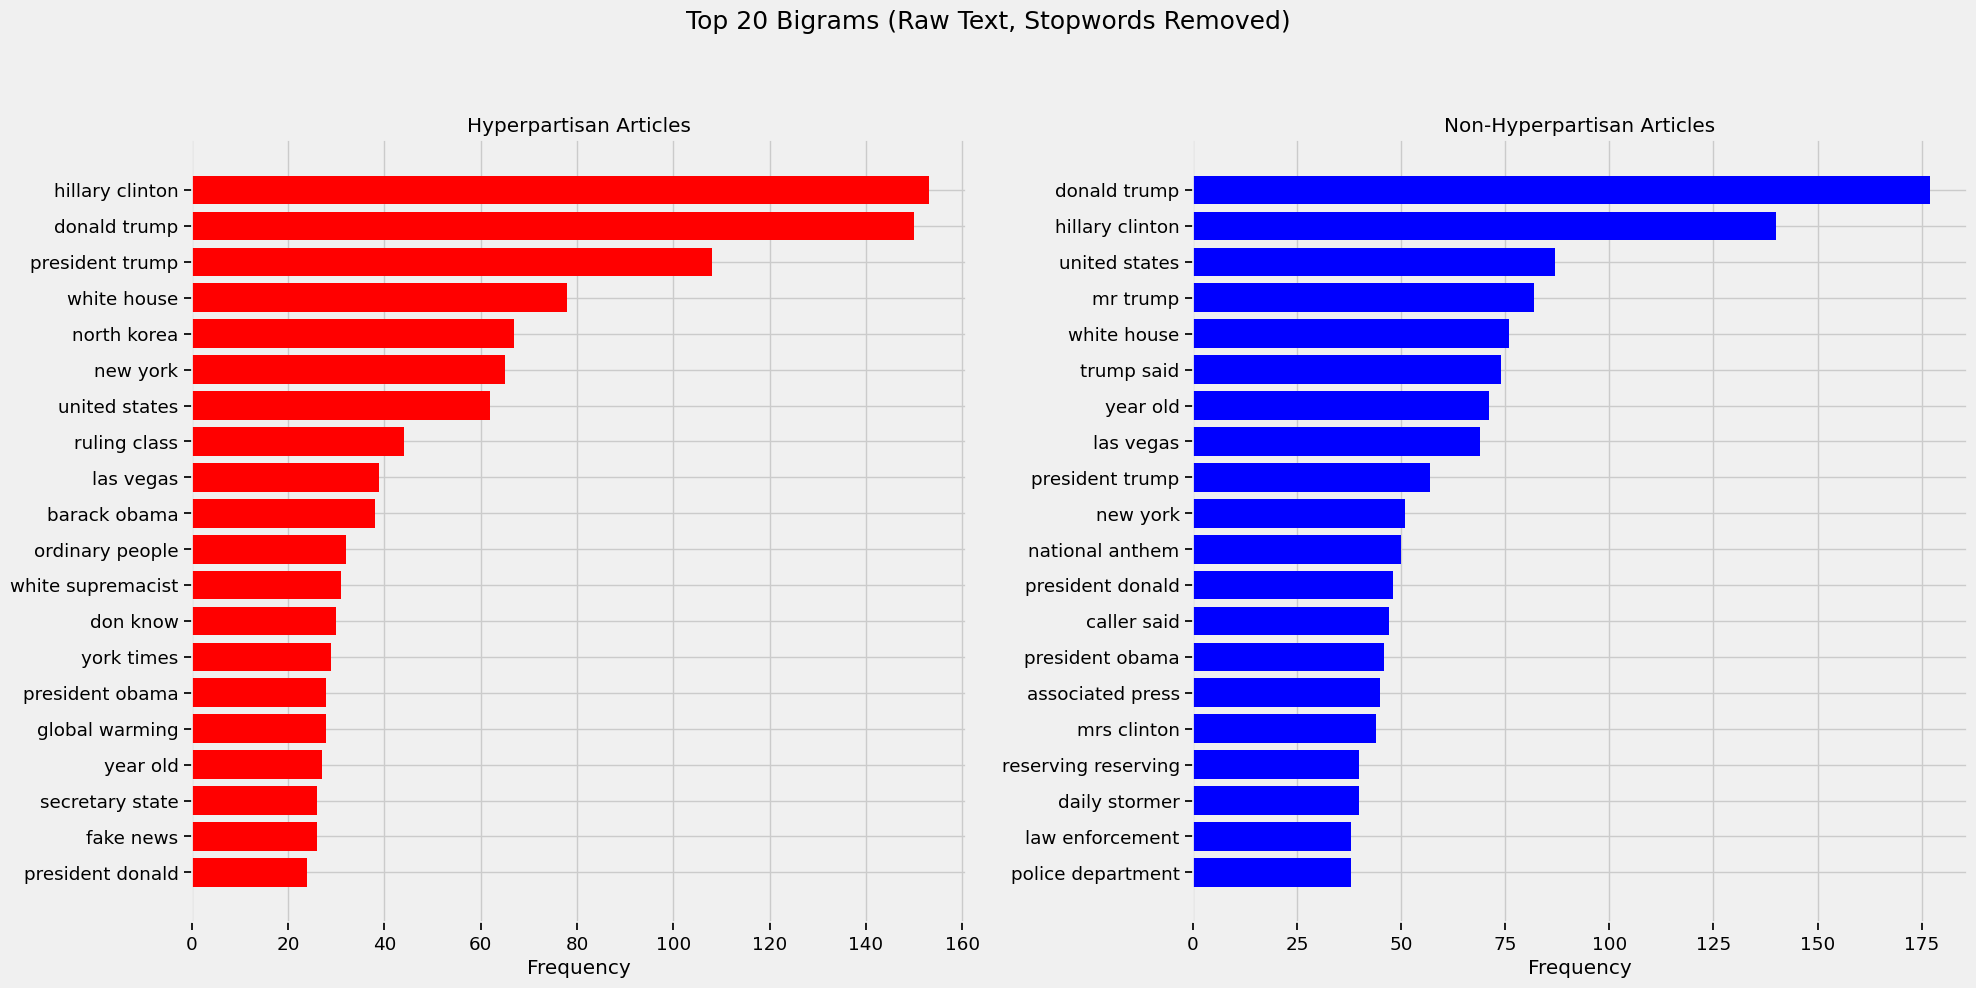

In [ ]:
print("\n===== COMMON WORDS AND PHRASES ANALYSIS (Raw Text) =====")

# Using the RAW 'text' column now
hyper_text_raw = train_df[train_df['hyperpartisan'] == True]['text']
non_hyper_text_raw = train_df[train_df['hyperpartisan'] == False]['text']

# --- Unigrams ---
# Use CountVectorizer with default token pattern and add English stopwords
unigram_vectorizer = CountVectorizer(stop_words='english', max_features=5000) # Limit features
X_unigram = unigram_vectorizer.fit_transform(train_df['text'])
sum_words = X_unigram.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in unigram_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Split frequencies by class
hyper_mask = train_df['hyperpartisan'].to_numpy(dtype=bool)
X_hyper_unigram = X_unigram[hyper_mask]
X_non_hyper_unigram = X_unigram[~hyper_mask]

hyper_sum_words = X_hyper_unigram.sum(axis=0)
non_hyper_sum_words = X_non_hyper_unigram.sum(axis=0)

hyper_freq = {word: hyper_sum_words[0, idx] for word, idx in unigram_vectorizer.vocabulary_.items()}
non_hyper_freq = {word: non_hyper_sum_words[0, idx] for word, idx in unigram_vectorizer.vocabulary_.items()}

hyper_top_words_raw = sorted(hyper_freq.items(), key=lambda item: item[1], reverse=True)[:30]
non_hyper_top_words_raw = sorted(non_hyper_freq.items(), key=lambda item: item[1], reverse=True)[:30]

# Plot top words comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Top 20 Unigrams (Raw Text, Stopwords Removed)', fontsize=18, y=1.02)

hyper_words = [word for word, freq in hyper_top_words_raw]
hyper_freqs = [freq for word, freq in hyper_top_words_raw]
ax1.barh(hyper_words[:20][::-1], hyper_freqs[:20][::-1], color='red')
ax1.set_title('Hyperpartisan Articles')
ax1.set_xlabel('Frequency')

non_hyper_words = [word for word, _ in non_hyper_top_words_raw]
non_hyper_freqs = [freq for _, freq in non_hyper_top_words_raw]
ax2.barh(non_hyper_words[:20][::-1], non_hyper_freqs[:20][::-1], color='blue')
ax2.set_title('Non-Hyperpartisan Articles')
ax2.set_xlabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("eda_top_words_raw.png")
plt.show()


# --- TF-IDF Distinctiveness ---
print("\n--- Distinctive Words (TF-IDF on Raw Text) ---")
tfidf_vectorizer_raw = TfidfVectorizer(max_features=1000, min_df=5, stop_words='english')
X_tfidf_raw = tfidf_vectorizer_raw.fit_transform(train_df['text'])
feature_names_raw = tfidf_vectorizer_raw.get_feature_names_out()

hyper_avg_raw = X_tfidf_raw[hyper_mask].mean(axis=0).A1
non_hyper_avg_raw = X_tfidf_raw[~hyper_mask].mean(axis=0).A1
diff_raw = hyper_avg_raw - non_hyper_avg_raw

top_hyper_idx_raw = diff_raw.argsort()[-20:][::-1]
top_non_hyper_idx_raw = diff_raw.argsort()[:20]

top_hyper_words_tfidf = [(feature_names_raw[i], diff_raw[i]) for i in top_hyper_idx_raw]
top_non_hyper_words_tfidf = [(feature_names_raw[i], -diff_raw[i]) for i in top_non_hyper_idx_raw] # Negate diff for score

# Plot distinctive words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Distinctive Words based on TF-IDF Difference (Raw Text)', fontsize=18, y=1.02)

hyper_dist_words = [word for word, score in top_hyper_words_tfidf]
hyper_dist_scores = [score for word, score in top_hyper_words_tfidf]
ax1.barh(hyper_dist_words[::-1], hyper_dist_scores[::-1], color='red')
ax1.set_title('More Common in Hyperpartisan')
ax1.set_xlabel('Difference in TF-IDF Score')

non_hyper_dist_words = [word for word, _ in top_non_hyper_words_tfidf]
non_hyper_dist_scores = [score for _, score in top_non_hyper_words_tfidf]
ax2.barh(non_hyper_dist_words[::-1], non_hyper_dist_scores[::-1], color='blue')
ax2.set_title('More Common in Non-Hyperpartisan')
ax2.set_xlabel('Difference in TF-IDF Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("eda_tfidf_diff_raw.png")
plt.show()


# --- Bigrams ---
print("\n--- Top Bigrams (Raw Text) ---")
bigram_vectorizer_raw = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=5000) # Use stopwords
X_bigram_raw = bigram_vectorizer_raw.fit_transform(train_df['text'])

X_hyper_bigram = X_bigram_raw[hyper_mask]
X_non_hyper_bigram = X_bigram_raw[~hyper_mask]

hyper_sum_bigrams = X_hyper_bigram.sum(axis=0)
non_hyper_sum_bigrams = X_non_hyper_bigram.sum(axis=0)

hyper_bigram_freq = {word: hyper_sum_bigrams[0, idx] for word, idx in bigram_vectorizer_raw.vocabulary_.items()}
non_hyper_bigram_freq = {word: non_hyper_sum_bigrams[0, idx] for word, idx in bigram_vectorizer_raw.vocabulary_.items()}

hyper_top_bigrams_raw = sorted(hyper_bigram_freq.items(), key=lambda item: item[1], reverse=True)[:20]
non_hyper_top_bigrams_raw = sorted(non_hyper_bigram_freq.items(), key=lambda item: item[1], reverse=True)[:20]


# Plot top bigrams comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Top 20 Bigrams (Raw Text, Stopwords Removed)', fontsize=18, y=1.02)

hyper_bigrams = [bigram for bigram, _ in hyper_top_bigrams_raw]
hyper_bigram_freqs = [freq for _, freq in hyper_top_bigrams_raw]
ax1.barh(hyper_bigrams[::-1], hyper_bigram_freqs[::-1], color='red')
ax1.set_title('Hyperpartisan Articles')
ax1.set_xlabel('Frequency')

non_hyper_bigrams = [bigram for bigram, _ in non_hyper_top_bigrams_raw]
non_hyper_bigram_freqs = [freq for _, freq in non_hyper_top_bigrams_raw]
ax2.barh(non_hyper_bigrams[::-1], non_hyper_bigram_freqs[::-1], color='blue')
ax2.set_title('Non-Hyperpartisan Articles')
ax2.set_xlabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("eda_top_bigrams_raw.png")
plt.show()

## 4. Sentiment Analysis (Raw Text)
Analyzing sentiment scores using VADER on the raw article text.


===== SENTIMENT ANALYSIS (Raw Text) =====
Calculating VADER sentiment scores for training data...
Sentiment scores calculated.


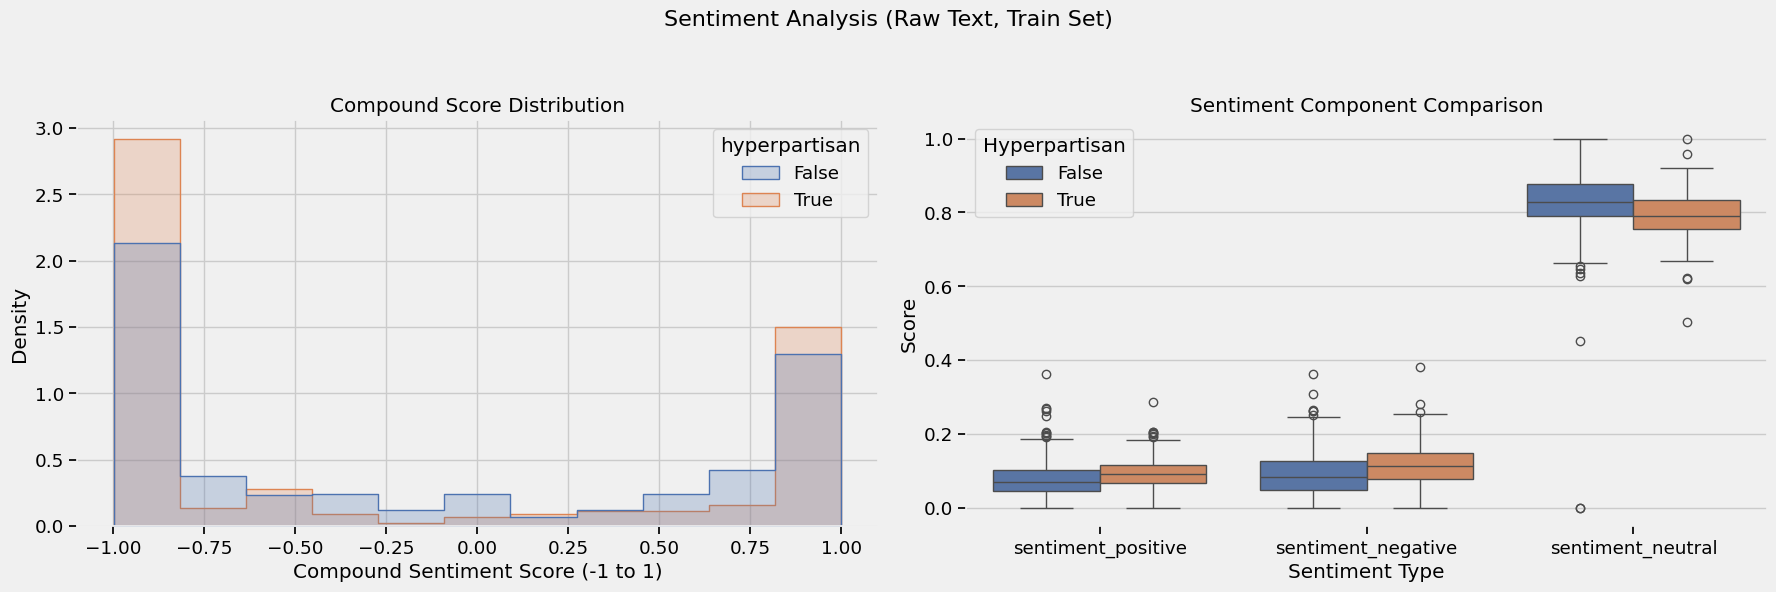


Sentiment compound score comparison (Train Set):
T-test p-value: 0.1073
Mean sentiment (hyperpartisan): -0.2598
Mean sentiment (non-hyperpartisan): -0.1490


In [ ]:
print("\n===== SENTIMENT ANALYSIS (Raw Text) =====")
sns.set_context("notebook", font_scale=1.2) # Reset context if needed

sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores on the full training set
print("Calculating VADER sentiment scores for training data...")
sentiment_results = train_df['text'].apply(lambda x: sid.polarity_scores(x) if pd.notna(x) else {'compound': 0, 'pos': 0, 'neg': 0, 'neu': 1})
train_df['sentiment_compound'] = sentiment_results.apply(lambda x: x['compound'])
train_df['sentiment_positive'] = sentiment_results.apply(lambda x: x['pos'])
train_df['sentiment_negative'] = sentiment_results.apply(lambda x: x['neg'])
train_df['sentiment_neutral'] = sentiment_results.apply(lambda x: x['neu'])
print("Sentiment scores calculated.")

# Create visualizations for sentiment
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Sentiment Analysis (Raw Text, Train Set)', fontsize=16, y=1.02)

# Compound sentiment distribution
sns.histplot(data=train_df, x='sentiment_compound', hue='hyperpartisan', element='step',
             stat='density', common_norm=False, ax=axes[0])
axes[0].set_title('Compound Score Distribution')
axes[0].set_xlabel('Compound Sentiment Score (-1 to 1)')

# Sentiment comparison boxplot
sentiment_data = pd.melt(train_df,
                         id_vars=['hyperpartisan'],
                         value_vars=['sentiment_positive', 'sentiment_negative', 'sentiment_neutral'],
                         var_name='sentiment_type', value_name='score')
sns.boxplot(data=sentiment_data, x='sentiment_type', y='score', hue='hyperpartisan', ax=axes[1])
axes[1].set_title('Sentiment Component Comparison')
axes[1].set_xlabel('Sentiment Type')
axes[1].set_ylabel('Score')
axes[1].legend(title='Hyperpartisan')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("eda_sentiment_raw.png")
plt.show()

# Statistical tests for sentiment
print("\nSentiment compound score comparison (Train Set):")
hyper_sentiment = train_df[train_df['hyperpartisan'] == True]['sentiment_compound']
non_hyper_sentiment = train_df[train_df['hyperpartisan'] == False]['sentiment_compound']
if not hyper_sentiment.empty and not non_hyper_sentiment.empty:
    sentiment_ttest = stats.ttest_ind(hyper_sentiment.dropna(), non_hyper_sentiment.dropna(), equal_var=False, nan_policy='omit')
    print(f"T-test p-value: {sentiment_ttest.pvalue:.4g}")
    print(f"Mean sentiment (hyperpartisan): {hyper_sentiment.mean():.4f}")
    print(f"Mean sentiment (non-hyperpartisan): {non_hyper_sentiment.mean():.4f}")
else:
    print("Could not perform sentiment t-test (empty group or all NaN).")


# Examining correlations between numerical features (calculated on raw text where applicable) and the hyperpartisan label in the training data.


===== CORRELATION ANALYSIS (Train Set) =====
Columns used for correlation: ['word_count_raw', 'unique_word_count_raw', 'vocab_diversity_raw', 'sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'hyperpartisan_num']


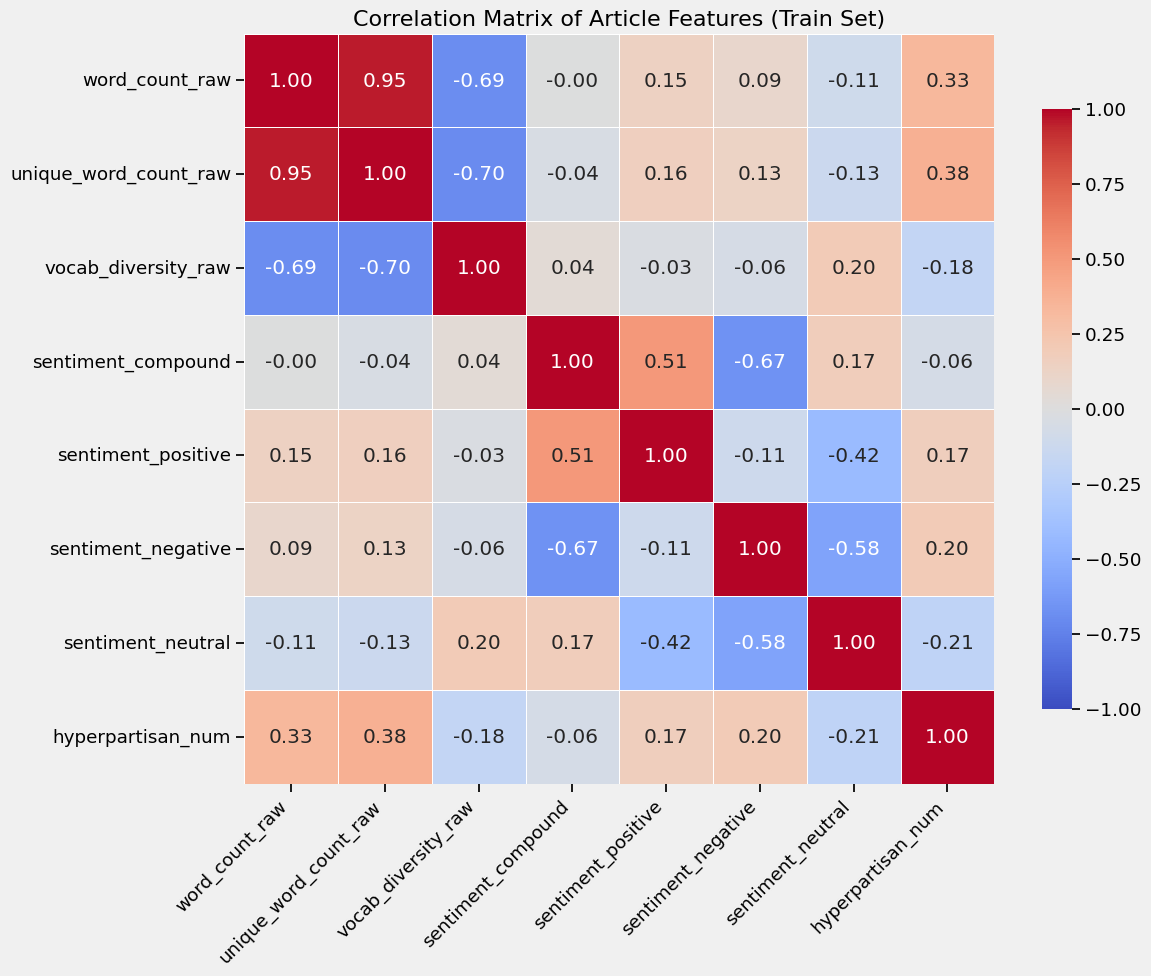


Features correlated with hyperpartisan classification (Train Set):
hyperpartisan_num        1.000000
unique_word_count_raw    0.376410
word_count_raw           0.328650
sentiment_negative       0.201648
sentiment_positive       0.167178
sentiment_compound      -0.064376
vocab_diversity_raw     -0.184410
sentiment_neutral       -0.207430
Name: hyperpartisan_num, dtype: float64


In [15]:
print("\n===== CORRELATION ANALYSIS (Train Set) =====")
sns.set_context("notebook", font_scale=1.2) # Reset context if needed

# Add a numeric hyperpartisan column for correlation
train_df['hyperpartisan_num'] = train_df['hyperpartisan'].astype(int)

# Select numeric columns for correlation analysis (using raw text features)
numeric_cols = ['word_count_raw', 'unique_word_count_raw', 'vocab_diversity_raw',
                'sentiment_compound', 'sentiment_positive', 'sentiment_negative',
                'sentiment_neutral', 'hyperpartisan_num']

# Ensure columns exist before calculating correlation
cols_exist = [col for col in numeric_cols if col in train_df.columns]
print(f"Columns used for correlation: {cols_exist}")

if len(cols_exist) > 1: # Need at least 2 columns
    corr_matrix = train_df[cols_exist].corr()

    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix of Article Features (Train Set)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("eda_correlation_raw.png")
    plt.show()

    # Focus on correlations with hyperpartisan label
    if 'hyperpartisan_num' in corr_matrix.columns:
        hyperpartisan_corr = corr_matrix['hyperpartisan_num'].sort_values(ascending=False)
        print("\nFeatures correlated with hyperpartisan classification (Train Set):")
        print(hyperpartisan_corr)
    else:
        print("Could not calculate correlations with hyperpartisan label.")
else:
     print("Not enough numeric columns found to calculate correlation matrix.")

## 6. Summary of Findings from Official Training Data
Summarizing the key characteristics and differences observed in the official training dataset.

In [ ]:
print("\n===== SUMMARY OF FINDINGS (Official Training Data) =====\n")

# Dataset overview
print(f"Training dataset contains {len(train_df)} articles")
print(f"{train_df['hyperpartisan'].sum()} hyperpartisan articles ({train_df['hyperpartisan'].mean()*100:.1f}%)")
print(f"{len(train_df) - train_df['hyperpartisan'].sum()} non-hyperpartisan articles ({(1-train_df['hyperpartisan'].mean())*100:.1f}%)")

# Key differences
print("\nKey differences between hyperpartisan and non-hyperpartisan articles (Train Set):")

# Word count (raw)
if 'word_count_raw' in train_df.columns:
    hyper_mean_words = train_df[train_df['hyperpartisan'] == True]['word_count_raw'].mean()
    non_hyper_mean_words = train_df[train_df['hyperpartisan'] == False]['word_count_raw'].mean()
    print(f"- Average word count (raw text): Hyperpartisan = {hyper_mean_words:.1f}, Non-hyperpartisan = {non_hyper_mean_words:.1f}")

# Vocabulary diversity (raw)
if 'vocab_diversity_raw' in train_df.columns:
    hyper_mean_diversity = train_df[train_df['hyperpartisan'] == True]['vocab_diversity_raw'].mean()
    non_hyper_mean_diversity = train_df[train_df['hyperpartisan'] == False]['vocab_diversity_raw'].mean()
    print(f"- Average vocabulary diversity (raw text): Hyperpartisan = {hyper_mean_diversity:.3f}, Non-hyperpartisan = {non_hyper_mean_diversity:.3f}")

# Publishers
print("\nPublisher insights:")
print(f"- Total unique publishers found: {train_df['publisher'].nunique()}")
# Find publishers with highest/lowest hyperpartisan ratios (min 5 articles)
if 'publisher_summary' in locals() and not publisher_summary.empty:
     min_articles_for_ratio = 5
     filtered_pubs = publisher_summary[publisher_summary['article_count'] >= min_articles_for_ratio]
     if not filtered_pubs.empty:
          top_hp_pubs = filtered_pubs.sort_values('hyperpartisan_ratio', ascending=False).head(5)
          bottom_hp_pubs = filtered_pubs.sort_values('hyperpartisan_ratio', ascending=True).head(5)
          print(f"- Publishers with highest hyperpartisan ratio (min {min_articles_for_ratio} articles):")
          for pub, data in top_hp_pubs.iterrows(): print(f"  - {pub} ({data['hyperpartisan_ratio']:.2f})")
          print(f"- Publishers with lowest hyperpartisan ratio (min {min_articles_for_ratio} articles):")
          for pub, data in bottom_hp_pubs.iterrows(): print(f"  - {pub} ({data['hyperpartisan_ratio']:.2f})")
     else:
          print("- Not enough publishers with sufficient articles to determine ratio reliably.")
else:
     print("- Publisher summary not available.")


# Most distinctive words (TF-IDF on raw text)
if 'top_hyper_words_tfidf' in locals():
    print("\nTop 5 Distinctive words in hyperpartisan articles (TF-IDF Raw Text):")
    for word, score in top_hyper_words_tfidf[:5]: print(f"- {word}")

if 'top_non_hyper_words_tfidf' in locals():
    print("\nTop 5 Distinctive words in non-hyperpartisan articles (TF-IDF Raw Text):")
    for word, score in top_non_hyper_words_tfidf[:5]: print(f"- {word}")

# Most common bigrams (Raw text)
if 'hyper_top_bigrams_raw' in locals():
    print("\nTop 5 Common bigrams in hyperpartisan articles (Raw Text):")
    for bigram, freq in hyper_top_bigrams_raw[:5]: print(f"- {bigram} ({freq})")

if 'non_hyper_top_bigrams_raw' in locals():
    print("\nTop 5 Common bigrams in non-hyperpartisan articles (Raw Text):")
    for bigram, freq in non_hyper_top_bigrams_raw[:5]: print(f"- {bigram} ({freq})")

# Sentiment
if 'sentiment_compound' in train_df.columns:
     hyper_mean_sent = train_df[train_df['hyperpartisan'] == True]['sentiment_compound'].mean()
     non_hyper_mean_sent = train_df[train_df['hyperpartisan'] == False]['sentiment_compound'].mean()
     print(f"\nSentiment (VADER Compound): Hyper = {hyper_mean_sent:.3f}, Non-Hyper = {non_hyper_mean_sent:.3f} (Difference likely not significant)")

print("\nEDA on official training data complete.")


===== SUMMARY OF FINDINGS (Official Training Data) =====

Training dataset contains 645 articles
238 hyperpartisan articles (36.9%)
407 non-hyperpartisan articles (63.1%)

Key differences between hyperpartisan and non-hyperpartisan articles (Train Set):
- Average word count (raw text): Hyperpartisan = 744.0, Non-hyperpartisan = 396.6
- Average vocabulary diversity (raw text): Hyperpartisan = 0.495, Non-hyperpartisan = 0.549

Publisher insights:
- Total unique publishers found: 1
- Publishers with highest hyperpartisan ratio (min 5 articles):
  - unknown (0.37)
- Publishers with lowest hyperpartisan ratio (min 5 articles):
  - unknown (0.37)

Top 5 Distinctive words in hyperpartisan articles (TF-IDF Raw Text):
- trump
- hillary
- clinton
- american
- president

Top 5 Distinctive words in non-hyperpartisan articles (TF-IDF Raw Text):
- police
- said
- twitter
- isis
- officer

Top 5 Common bigrams in hyperpartisan articles (Raw Text):
- hillary clinton (153)
- donald trump (150)
- presi